## HSPC dataset - marker geens

In this notebook we will use gene markers to identify five main populations in the HSPC compartment: hematopoietic stem cells (HSCs), Erythroid progenitors, eosinophil/basinophil progenitors, megakaryocyte progenitors and myeloid progenitors. 

In [1]:
### load libraries

# standard libraries
import numpy as np
import pandas as pd

# single-cell libraries
import scvelo as scv #used for reading loom file
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures


### Load original dataset
Here, we load the spliced and unspliced matrices from the HSPC dataset using a loom file (`HSPC.loom`). You can download this file and all other needed files from our Github repository (find it under datasets/HSPC). The dataset consists of murine HSPCs. The HSPCs in this dataset were acquired by sorting bone marrow cells using a broad Lin-, c-Kit+ (LK) gating strategy. Additionally, the datasets has been enriched for long-term hematopoietic stem cells (HSCs), which are usually less abundant than other populations.

In [2]:
### load loom file subset
hspc_path = "../datasets/HSPC/HSPC.loom"
adata = ad.read_loom(hspc_path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In the original processing of the dataset some cells and genes were removed during quality control (for example because they are doublets). Therefore we remove those cells and genes here as well. 

In [3]:
### load cells selected in qc
load_path = "../datasets/HSPC/cells_after_qc.csv"
cell_after_qc = np.loadtxt(load_path, dtype=str)

In [4]:
### change cellnames in loom file to match the cellnames from the original dataset
cellnames = [cellname.replace('possorted_genome_bam_YBF44:','') for cellname in adata.obs_names]
cellnames = [cellname.replace('x','-1-PBS') for cellname in cellnames]
adata.obs_names = cellnames

In [5]:
### remove cells that are filtered out in original pipeline (doublets, etc.)
adata = adata[cell_after_qc,:]

In [6]:
### make names of genes unique
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
### load genes selected in qc
load_path = "../datasets/HSPC/genes_after_qc.csv"
genes_after_qc = np.loadtxt(load_path, dtype=str)

In [8]:
### remove genes that are filtered out in original pipeline 
shared_genes = np.intersect1d(adata.var_names, genes_after_qc)
adata = adata[:,shared_genes]

In this notebook we will define the different populations in the HSPC dataset. To compare these annotations to the original annotations, we will also load the originally assigned cell types into the AnnData object. Additionally, we also load the original UMAP coordinates.

In [9]:
### load original clusters 
load_path = "../datasets/HSPC/original_clusters.csv"
original_clusters = pd.read_csv(load_path, index_col=0)
adata.obs["original_clusters"] = original_clusters

Trying to set attribute `.obs` of view, copying.


In [10]:
### load original colors
original_colors = ['#98df8a', '#d62728', '#aec7e8', '#17becf', '#8c564b', '#b5bd61',
                   '#e377c2', '#279e68', '#ff7f0e', '#aa40fc', '#1f77b4', '#ffbb78']
adata.uns["original_clusters_colors"] = original_colors

In [11]:
### load original UMAP
load_path = "../datasets/HSPC/original_UMAP.csv"
original_umap = np.genfromtxt(load_path, delimiter=',')
adata.obsm["original_umap"] = original_umap

Last, we remove two clusters that have a very low number of cells.

In [12]:
### remove smaller populations
small_populations = ["Eosinophils", "Monocytes"]
adata = adata[[i not in small_populations for i in adata.obs["original_clusters"]],:]

In [13]:
adata_copy = adata.copy()

### Assign cell types to dataset
Here, we will use gene markers to identify five main populations in the HSPC compartment: hematopoietic stem cells (HSCs), Erythroid progenitors, eosinophil/basinophil progenitors, megakaryocyte progenitors and myeloid progenitors. 

In [14]:
### load libraries for plotting
import matplotlib.colors
from matplotlib import colors
from matplotlib import cm as cmx
import sklearn as sk
from matplotlib.colors import LinearSegmentedColormap #for own cmap

In [15]:
### process adata for scoring marker genes
adata.X = adata.layers["spliced"].todense() + adata.layers["unspliced"].todense()
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
sc.pp.scale(adata)

In [16]:
### load gene sets
geneset_path = "../datasets/HSPC/HSPC_marker_genes.csv"
geneset = pd.read_csv(geneset_path, sep=";")

In [17]:
### create empty dataframe
df_geneset_scores = pd.DataFrame(index=adata.obs.index) 

In [18]:
### loop over each cell type in the geneset and score
for idx, celltype in enumerate(geneset.columns.values):
    genes = np.intersect1d(list(geneset.iloc[:, idx]),adata.var_names)
    sc.tl.score_genes(adata, genes, score_name="geneset_score")
    df_geneset_scores[celltype] = list(adata.obs["geneset_score"])
    df_geneset_scores[celltype] = df_geneset_scores[celltype] - min(df_geneset_scores[celltype])
    df_geneset_scores[celltype] = df_geneset_scores[celltype] / max(df_geneset_scores[celltype])
    df_geneset_scores[celltype] = df_geneset_scores[celltype]*10
    del adata.obs["geneset_score"]

In [19]:
celltype= "HSCs"
colors = ["grey","grey","lightskyblue","dodgerblue"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=custom_cmap)
rgbs = scalarMap.to_rgba(df_geneset_scores.loc[:,celltype].values)[:,0:3]
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in rgbs]
df_geneset_scores[celltype+'_colors'] = colors

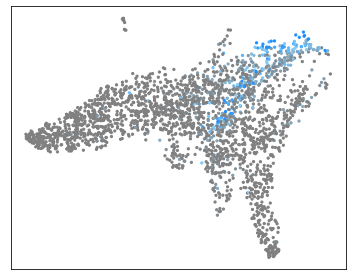

In [20]:
### score for genes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores.loc[:,"HSCs_colors"].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_HSC_marked_original_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [21]:
celltype= "MEP"
colors = ["grey", "grey","grey", 'gold','goldenrod']
colors = ["grey","grey","grey","grey",'#fff7bc','#fee391','#fec44f','#fe9929']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=6)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=custom_cmap)
rgbs = scalarMap.to_rgba(df_geneset_scores.loc[:,celltype].values)[:,0:3]
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in rgbs]
df_geneset_scores[celltype+'_colors'] = colors

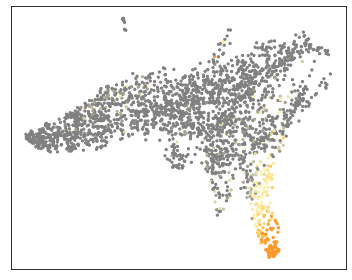

In [22]:
### score for genes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores.loc[:,celltype+"_colors"].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_erythroid_marked_original_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [23]:
celltype= "mk_prog"
colors = ["grey","grey","rebeccapurple","indigo"]
colors = ["grey","grey","grey","grey","#9e9ac8","#756bb1","#54278f"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=custom_cmap)
rgbs = scalarMap.to_rgba(df_geneset_scores.loc[:,celltype].values)[:,0:3]
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in rgbs]
df_geneset_scores[celltype+'_colors'] = colors

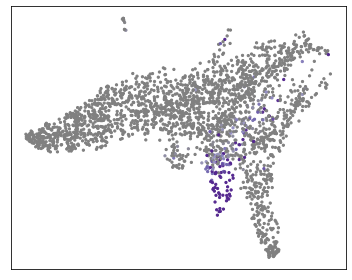

In [24]:
### score for genes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores.loc[:,celltype+"_colors"].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_MK_marked_original_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [25]:
celltype= "eos_prog"
colors = ["grey","grey","grey","darkorange", "saddlebrown"]
colors = ["grey", "grey","seagreen"]#"#dfc27d","#a6611a"]#"#df65b0","#980043"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=custom_cmap)
rgbs = scalarMap.to_rgba(df_geneset_scores.loc[:,celltype].values)[:,0:3]
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in rgbs]
df_geneset_scores[celltype+'_colors'] = colors

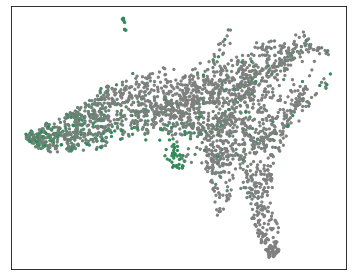

In [26]:
### score for genes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores.loc[:,celltype+"_colors"].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_eos-baso_marked_original_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [27]:
celltype= "neutro_prog"
colors = ["grey","grey","grey","red","darkred","darkred"]
colors= ["grey","grey","grey","#fd8d3c","#e31a1c","#800026"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=7)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=custom_cmap)
rgbs = scalarMap.to_rgba(df_geneset_scores.loc[:,celltype].values)[:,0:3]
colors = [matplotlib.colors.rgb2hex(rgb) for rgb in rgbs]
df_geneset_scores[celltype+'_colors'] = colors

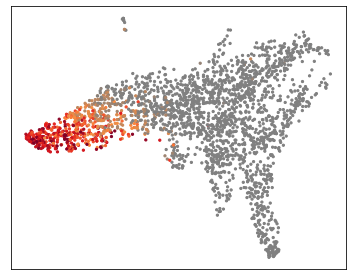

In [28]:
### score for genes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores.loc[:,celltype+"_colors"].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_myeloid_marked_original_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [29]:
df_geneset_scores["max"] = df_geneset_scores.max(axis=1)
df_geneset_scores["celltype"] = df_geneset_scores.iloc[:,0:len(geneset.columns.values)].idxmax(axis=1)
df_geneset_scores["final_colors"] = [df_geneset_scores[celltype+"_colors"][idx] for idx, celltype in enumerate(df_geneset_scores["celltype"])]

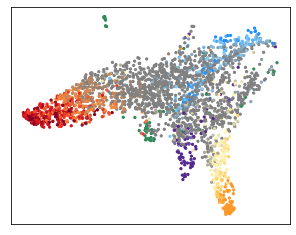

In [30]:
### plot all scores in the same umap
fig, ax = plt.subplots(1, 1, figsize=(5, 4), frameon=False)
ax.scatter(original_umap[:,0], original_umap[:,1], color=df_geneset_scores['final_colors'].values, s=5)
ax.set_yticks([])
ax.set_xticks([])

# save figure
save_path = "../figures/HSPC/HSPC_new_clusters_original_umap.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [31]:
df_geneset_scores['final_colors'].values

array(['#808080', '#b7b39a', '#808080', ..., '#808080', '#808080',
       '#808080'], dtype=object)

In [32]:
### save colors from different cell types
save_path = "../datasets/HSPC/celltypes_colors.csv"
np.savetxt(save_path, df_geneset_scores['final_colors'].values, fmt="%s") 

In [33]:
df_geneset_scores["scanpy_celltypes"] = "none"
df_geneset_scores.loc[(df_geneset_scores['max'] >= 3.5)&(df_geneset_scores['celltype']=="MEP"), 'scanpy_celltypes'] = "MEP"
df_geneset_scores.loc[(df_geneset_scores['max'] >= 4.5)&(df_geneset_scores['celltype']=="neutro_prog"), 'scanpy_celltypes'] = "neutro_prog"
df_geneset_scores.loc[(df_geneset_scores['max'] >= 2)&(df_geneset_scores['celltype']=="HSCs"), 'scanpy_celltypes'] = "HSCs"
df_geneset_scores.loc[(df_geneset_scores['max'] >= 2)&(df_geneset_scores['celltype']=="mk_prog"), 'scanpy_celltypes'] = "mk_prog"
df_geneset_scores.loc[(df_geneset_scores['max'] >= 2)&(df_geneset_scores['celltype']=="eos_prog"), 'scanpy_celltypes'] = "eos_prog"

In [34]:
adata.obs["clusters"] = df_geneset_scores["scanpy_celltypes"].values

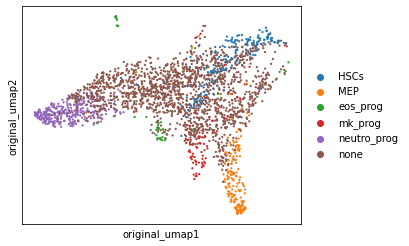

In [38]:
### plot HSPC-PBS dataset with clusters 
fig, ax = plt.subplots(1,1,figsize=(5,4))
sc.pl.embedding(adata, 'original_umap', color = 'clusters', size=20, 
           ax=ax, show=False, title="", )
plt.show()

In [39]:
adata.obs["clusters"].cat.categories

Index(['HSCs', 'MEP', 'eos_prog', 'mk_prog', 'neutro_prog', 'none'], dtype='object')

In [41]:
adata.uns["clusters_colors"] = ['seagreen','gold','dodgerblue','#54278f','#e31a1c','grey']

In [42]:
### convert each cluster to a cell type
old_to_new = {
    "HSCs":'HSCs',
    "MEP":'Erythroid prog.',
    "eos_prog":'Eo/basinophil prog.',
    "mk_prog":'Megakaryocyte prog.',
    "neutro_prog":'Myeloid prog.',
    "none":None,
}
adata.obs['clusters'] = (adata.obs['clusters'].map(old_to_new).astype('category'))

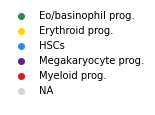

In [44]:
### plot legend
fig, ax = plt.subplots(1,1,figsize=(0,0))
sc.pl.embedding(adata, 'original_umap', color = 'clusters', size=20, 
           ax=ax, show=False, title="", )
ax.set_ylabel("")
ax.set_xlabel("")
ax.legend(loc='lower center', bbox_to_anchor=(0, 0), ncol=1, frameon=False)

# save figure
save_path = "../figures/HSPC/HSPC_legend_UMAP.pdf"
plt.savefig(save_path, dpi=300, transparent=True, bbox_inches='tight')
plt.show()